In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=90

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_diseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 120 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[0 1 1 0 2 0 1 2]


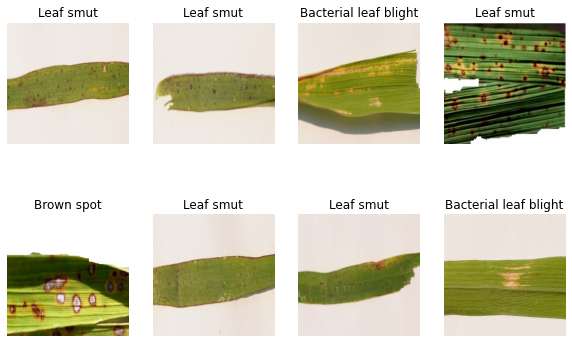

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

15

In [8]:
train_size = 0.8
len(dataset)*train_size

12.0

In [9]:
train_ds = dataset.take(12)
len(train_ds)

12

In [10]:
test_ds = dataset.skip(12)
len(test_ds)

3

In [11]:
val_size=0.1
len(dataset)*val_size

1.5

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)


12

In [17]:
len(val_ds)

1

In [18]:
len(test_ds)

2

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (8, 256, 256, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (8, 254, 254, 32)         896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (8, 127, 127, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (8, 125, 125, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (8, 62, 62, 64)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (8, 60, 60, 64)           36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (8, 30, 30, 64)          

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=90,
)

Epoch 1/90
12/12 [==============================] - 12s 676ms/step - loss: 1.1074 - accuracy: 0.3229 - val_loss: 1.0622 - val_accuracy: 0.6250
Epoch 2/90
12/12 [==============================] - 7s 556ms/step - loss: 1.0878 - accuracy: 0.3854 - val_loss: 0.8868 - val_accuracy: 0.6250
Epoch 3/90
12/12 [==============================] - 7s 563ms/step - loss: 1.0884 - accuracy: 0.2708 - val_loss: 1.0108 - val_accuracy: 0.3750
Epoch 4/90
12/12 [==============================] - 7s 533ms/step - loss: 1.0381 - accuracy: 0.4271 - val_loss: 0.7302 - val_accuracy: 0.3750
Epoch 5/90
12/12 [==============================] - 6s 502ms/step - loss: 1.0426 - accuracy: 0.4062 - val_loss: 0.7428 - val_accuracy: 0.5000
Epoch 6/90
12/12 [==============================] - 7s 578ms/step - loss: 0.9637 - accuracy: 0.4896 - val_loss: 0.7985 - val_accuracy: 0.5000
Epoch 7/90
12/12 [==============================] - 8s 616ms/step - loss: 0.8466 - accuracy: 0.6458 - val_loss: 0.6645 - val_accuracy: 0.6250
Epoch

In [27]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 251ms/step - loss: 0.0921 - accuracy: 1.0000


In [28]:
scores

[0.09209387749433517, 1.0]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 90, 'steps': 12}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

90

In [34]:
history.history['loss'][:5]

[1.1073707342147827,
 1.0878132581710815,
 1.088365077972412,
 1.0381182432174683,
 1.0425971746444702]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

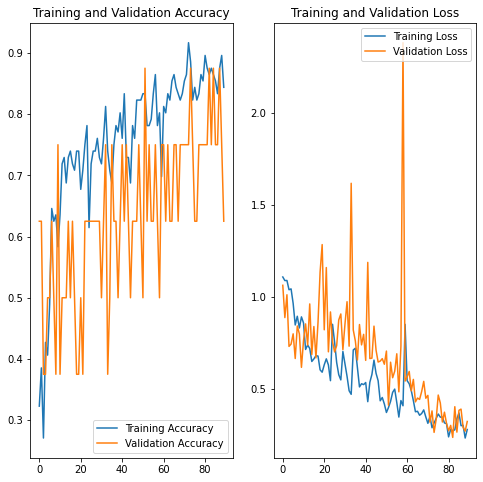

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial leaf blight
predicted label: Bacterial leaf blight


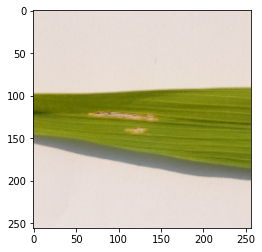

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

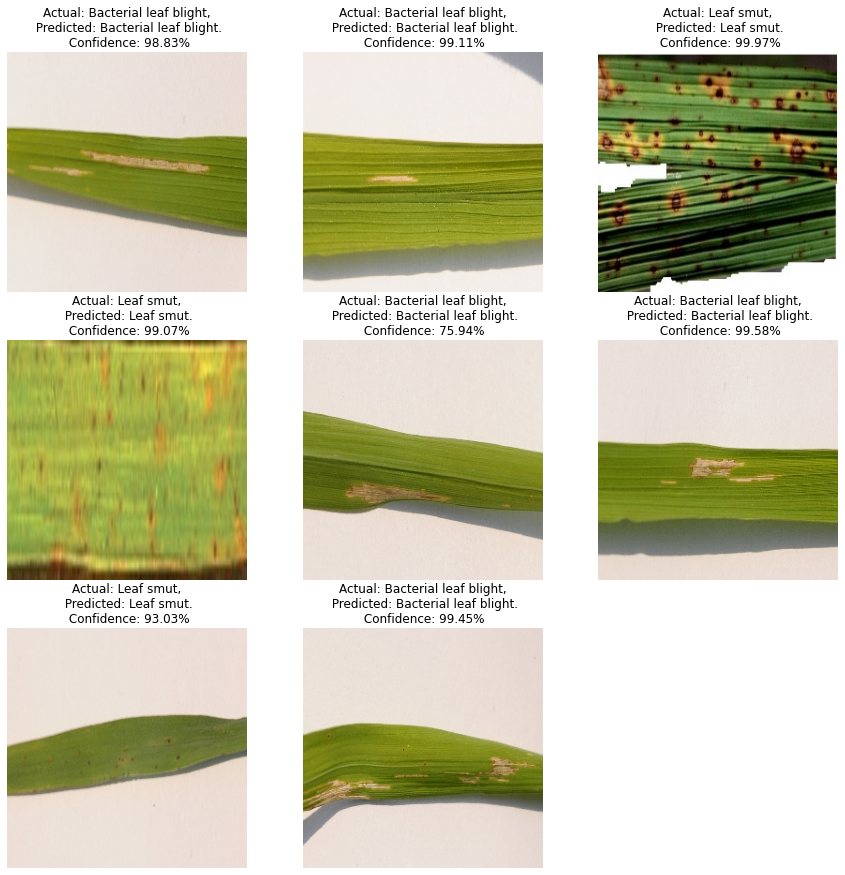

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/6\assets


In [41]:
model.save("../rice3.h5")

In [48]:
y_pred=model.predict_classes(test_ds)
y_true= class_names[labels[i]] 
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

D:\Program files\python\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


UnimplementedError: Cast string to int64 is not supported [Op:Cast]